# Instalación Librerias

In [ ]:
%pip install numpy

In [ ]:
%pip install matplotlib
%pip install pandas

In [ ]:
%pip install scipy

In [ ]:
%pip install seaborn

# Imporatción libreria y datos de prueba

In [285]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as signal
from scipy import fft
import os
import seaborn as sns
import scipy.stats as stats

In [250]:
# Carga de datos
file_path = 'ECGDataDenoised/MUSE_20180111_155115_19000.csv'
ecg_data = pd.read_csv(file_path,names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
ecg_data.head()

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,-165.33,-358.97,-121.710,270.25,-28.869,-231.16,448.39,636.52,618.45,-7.8987,-315.16,-570.84
1,-150.75,-336.81,-114.980,251.41,-23.883,-217.52,441.74,646.47,642.56,35.3890,-269.51,-532.21
2,-136.69,-315.56,-108.630,233.45,-19.126,-204.36,436.06,656.31,665.95,76.5720,-225.83,-495.39
3,-123.74,-296.23,-103.090,217.23,-14.815,-192.29,432.27,666.14,688.05,113.5100,-186.00,-461.84
4,-112.57,-279.75,-98.611,203.53,-11.213,-181.87,431.08,676.31,708.47,144.3000,-151.68,-432.56


In [251]:
# Obtención derivación 2 y vector de tiempo para las graficas
senal = ecg_data['II'].values
fs = 500
time = np.arange(0, senal.shape[0]/fs,1/fs)

# Tratamiento señal de prueba

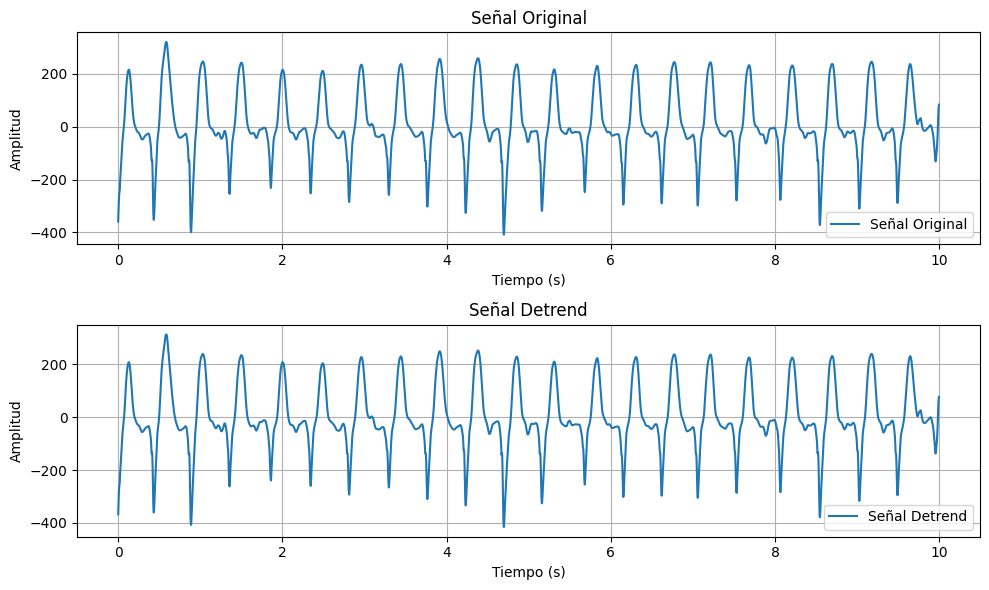

In [252]:
detrended_signal = signal.detrend(senal)

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(time, senal, label="Señal Original")
plt.title("Señal Original")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, detrended_signal, label="Señal Detrend")
plt.title("Señal Detrend")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

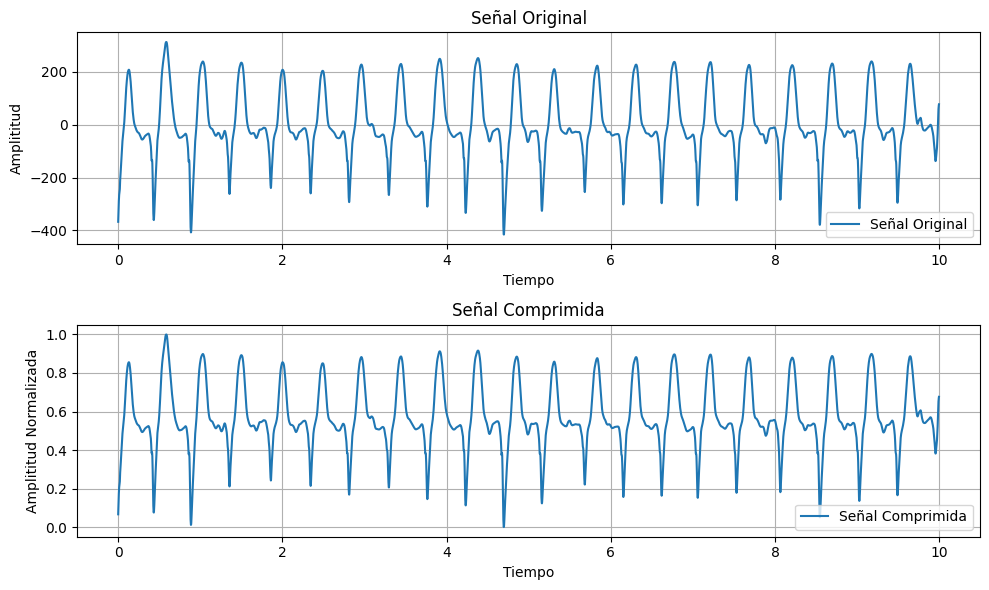

In [253]:

# función para comprimir la señal
def compress_signal(senal):
    x_min = np.min(senal)
    x_max = np.max(senal)
    compressed_signal = (senal - x_min) / (x_max - x_min)
    return compressed_signal

# Función comprimida
compressed_signal = compress_signal(detrended_signal)

# Plot original vs comprimida
plt.figure(figsize=(10, 6))

# Plot señal original
plt.subplot(2, 1, 1)
plt.plot(time,detrended_signal, label="Señal Original")
plt.title("Señal Original")
plt.xlabel("Tiempo")
plt.ylabel("Amplititud")
plt.grid(True)
plt.legend()

# Plot señal comprimida
plt.subplot(2, 1, 2)
plt.plot(time,compressed_signal, label="Señal Comprimida")
plt.title("Señal Comprimida")
plt.xlabel("Tiempo")
plt.ylabel("Amplititud Normalizada")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Analisis en frecuencia de la señal de prueba

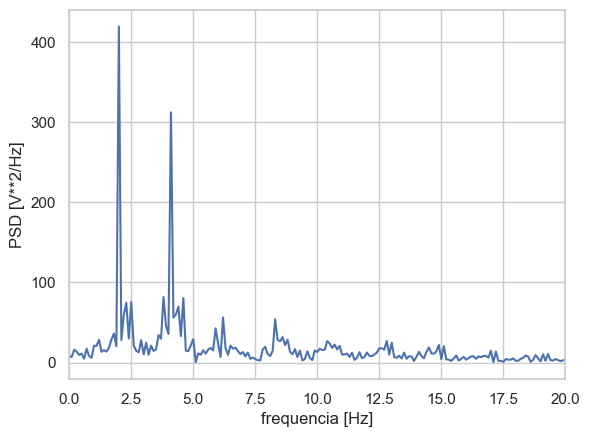

In [275]:
# Analisis de la señal comprimida mediante la FFT
EKG = fft.fft(compressed_signal)
## Quitar el primer valor de la señal (ya que es muy grande)
EKG = EKG[1:]
N = compressed_signal.shape[0]-1
f = np.arange(0,fs,fs/N)
plt.plot(f, np.abs(EKG))
plt.xlim([0,20])
plt.xlabel('frequencia [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

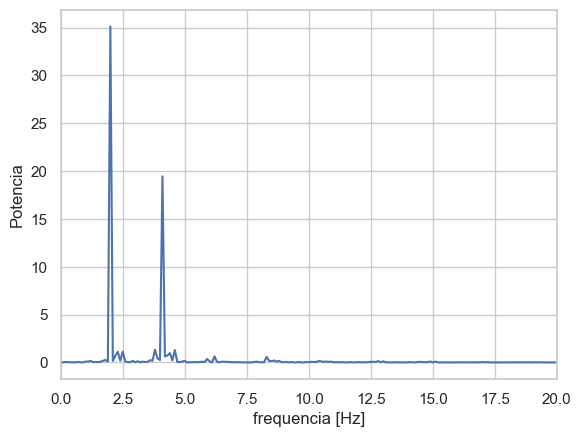

Frecuencia de Máxima Potencia (fMP):  2.000400080016003


In [276]:
#Cálculo de la potrencia y la frecuencia de maxíma potencia
plt.plot(f, np.power(np.abs(EKG),2)/N)
plt.xlim([0,20])
plt.xlabel('frequencia [Hz]')
plt.ylabel('Potencia')
plt.show()
positive_power = np.power(np.abs(EKG),2)/N
max_power_index = np.argmax(positive_power)
max_power_freq = f[max_power_index]
print("Frecuencia de Máxima Potencia (fMP): ", max_power_freq)

/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/3268768.py:47: RuntimeWarning: invalid value encountered in divide
  bicoherence = np.abs(bispectrum_sum) / denominator_sum
/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/3268768.py:50: RuntimeWarning: invalid value encountered in greater
  significant_bicoherence = np.where(bicoherence > significance_threshold, bicoherence, 0)


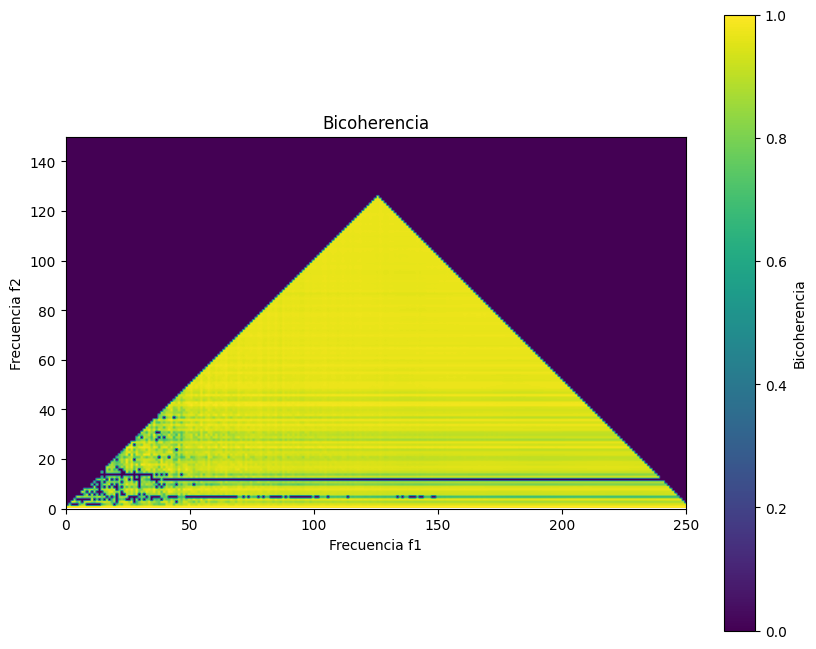

Sumatoria frecuancias significativas en Biocoherencia (sFSB):  15302


In [256]:
# Función para calcular el bispectro
def calculate_bispectrum(senal, segment_length, sampling_rate):
    # Teorema de Nyquist
    f_max = sampling_rate / 2
    
    # Numero de segmentos (10 en nuestro caso pues la señal tiene menos puntos de lo reportado en el articulo ejemplo)
    N = len(senal) // segment_length
    segments = np.array_split(senal, N)
    
    # Inicializar el bispectro
    bispectrum = np.zeros((segment_length, segment_length), dtype=complex)

    # Calcular biespectro segmento por segmento
    for j in range(N):
        X = fft.fft(segments[j])
        for f1 in range(segment_length):
            for f2 in range(f1+1):  # f2 <= f1
                if f1 + f2 <= f_max:  # f1 + f2 <= fmax
                    bispectrum[f1, f2] += X[f1] * X[f2] * np.conj(X[f1 + f2])

    bispectrum /= N
    return bispectrum

# Función para calcular el bicoherencia
def calculate_bicoherence(senal, segment_length, sampling_rate, significance_threshold):
    # Teorema de Nyquist
    f_max = sampling_rate / 2
    
    # Numero de segmentos
    N = len(senal) // segment_length
    segments = np.array_split(senal, N)
    
    # Inicializar el bispectro y el denominador
    bispectrum_sum = np.zeros((segment_length, segment_length), dtype=complex)
    denominator_sum = np.zeros((segment_length, segment_length), dtype=complex)
    
    for j in range(N):
        X = fft.fft(segments[j])
        for f1 in range(segment_length):
            for f2 in range(f1+1):  # f2 <= f1
                if f1 + f2 <= f_max:  # f1 + f2 <= fmax
                    bispectrum_value = X[f1] * X[f2] * np.conj(X[f1 + f2])
                    bispectrum_sum[f1, f2] += bispectrum_value
                    denominator_sum[f1, f2] += np.abs(X[f1] * X[f2] * np.conj(X[f1 + f2]))
    
    # Cálcula la bicoherencia
    bicoherence = np.abs(bispectrum_sum) / denominator_sum
    
    # Limite de significancia del 80%
    significant_bicoherence = np.where(bicoherence > significance_threshold, bicoherence, 0)
    
    return significant_bicoherence

senal = compressed_signal
segment_length = 500  # Largo del segmento (500 puntos en este caso)
sampling_rate = 500  # fs=500 Hz

# Frecuencia de Nyquist
f_max = sampling_rate / 2

# Calculamos el umbral de significancia y numero de segmentos N (10)
N_segments = len(senal) // segment_length
significance_threshold = np.sqrt(9.2 / (2 * N_segments))

bispectrum = calculate_bispectrum(senal, segment_length, sampling_rate)
bicoherence = calculate_bicoherence(senal, segment_length, sampling_rate, significance_threshold)

# Plot en la región triangular 
plt.figure(figsize=(10, 8))
plt.imshow(np.abs(bicoherence.T), extent=[0, segment_length, 0, segment_length], origin='lower') # Transpose para que la gráfica sea igual al artículo
plt.title('Bicoherencia')
plt.xlabel('Frecuencia f1')
plt.ylabel('Frecuencia f2')
plt.colorbar(label='Bicoherencia')
plt.xlim([0,250]) # Limites de la gráfica para limitarlo a los resultados más relevantes
plt.ylim([0,150]) # Limites de la gráfica para limitarlo a los resultados más relevantes
plt.show()
print("Sumatoria frecuancias significativas en Biocoherencia (sFSB): ",np.sum(bicoherence>0.7))#Número de puntos con bicoherencia mayor a 0.7


# Carga Masiva de Datos y proceso iterativo AFIB

In [222]:
file_path = 'Diagnostics.csv'
diagnos_data = pd.read_csv(file_path)
diagnos_data.head()


,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354


In [223]:
AFIB_pacients = diagnos_data.loc[diagnos_data['Rhythm'] == 'AFIB', 'FileName']
print(len(AFIB_pacients.tolist()))

1780


In [226]:
folder_dir = 'ECGDataDenoised/'
registros=[]
for file in os.listdir(folder_dir):
    if file[:-4] in AFIB_pacients.tolist():
        registro=[]
        registro.append(file[:-4])
        registro.append('AFIB')
        dir = folder_dir + file
        ecg_data = pd.read_csv(dir,names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
        senal = ecg_data['II'].values
        fs = 500
        time = np.arange(0, senal.shape[0]/fs,1/fs)
        detrended_signal = signal.detrend(senal)
        compressed_signal = compress_signal(detrended_signal)
        EKG = fft.fft(compressed_signal)
        EKG = EKG[1:]
        N = compressed_signal.shape[0]-1
        f = np.arange(0,fs,fs/N)
        positive_power = np.power(np.abs(EKG),2)/N
        max_power_index = np.argmax(positive_power)
        max_power_freq = f[max_power_index]
        registro.append(max_power_freq)
        senal = compressed_signal
        segment_length = 500  # Largo del segmento (500 puntos en este caso)
        sampling_rate = 500  # fs=500 Hz
        significance_threshold = np.sqrt(9.2 / (2 * N_segments))
        bicoherence = calculate_bicoherence(senal, segment_length, sampling_rate, significance_threshold)
        registro.append(np.sum(bicoherence>0.7))#Número de puntos con bicoherencia mayor a 0.7
        registros.append(registro)

print(len(registros))



/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/3268768.py:47: RuntimeWarning: invalid value encountered in divide
  bicoherence = np.abs(bispectrum_sum) / denominator_sum
/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/3268768.py:50: RuntimeWarning: invalid value encountered in greater
  significant_bicoherence = np.where(bicoherence > significance_threshold, bicoherence, 0)
/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/3268768.py:47: RuntimeWarning: invalid value encountered in divide
  bicoherence = np.abs(bispectrum_sum) / denominator_sum
/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/3268768.py:50: RuntimeWarning: invalid value encountered in greater
  significant_bicoherence = np.where(bicoherence > significance_threshold, bicoherence, 0)
/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/3268768.py:47: RuntimeWarning: invalid value encountered in divide
  bicoherence = np.abs(bispectrum_sum) / denomi

1780


/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/3268768.py:47: RuntimeWarning: invalid value encountered in divide
  bicoherence = np.abs(bispectrum_sum) / denominator_sum
/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/3268768.py:50: RuntimeWarning: invalid value encountered in greater
  significant_bicoherence = np.where(bicoherence > significance_threshold, bicoherence, 0)


In [227]:
columnas = ['Registro', 'Estado', 'fMP', 'sFSB']
df_AFIB = pd.DataFrame(registros,columns=columnas)
df_AFIB.sort_values(by=['Registro'])
#Almacenamos la tabla de análisis como CSV en la carpeta del proyecto
df_AFIB.to_csv('Resultados/df_AFIB.csv', index=False)

In [231]:
file_path = 'Resultados/df_AFIB.csv'
resultado_AFIB = pd.read_csv(file_path)
resultado_AFIB.head()

,Registro,Estado,fMP,sFSB
0,MUSE_20180112_074345_57000,AFIB,4.70094,3374
1,MUSE_20180113_182054_43000,AFIB,3.10062,1086
2,MUSE_20180116_181851_46000,AFIB,7.60152,3414
3,MUSE_20180116_125104_99000,AFIB,9.00180,2012
4,MUSE_20180118_135259_10000,AFIB,1.40028,3759


# Proceso iterativo SB

In [240]:
SB_pacients = diagnos_data.loc[diagnos_data['Rhythm'] == 'SB', 'FileName']
print(len(SB_pacients.tolist()))

3889


In [242]:
folder_dir = 'ECGDataDenoised/'
registros=[]
for file in os.listdir(folder_dir):
    if file[:-4] in SB_pacients.tolist():
        registro=[]
        registro.append(file[:-4])
        registro.append('SB')
        dir = folder_dir + file
        ecg_data = pd.read_csv(dir,names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
        senal = ecg_data['II'].values
        fs = 500
        time = np.arange(0, senal.shape[0]/fs,1/fs)
        detrended_signal = signal.detrend(senal)
        compressed_signal = compress_signal(detrended_signal)
        EKG = fft.fft(compressed_signal)
        EKG = EKG[1:]
        N = compressed_signal.shape[0]-1
        f = np.arange(0,fs,fs/N)
        positive_power = np.power(np.abs(EKG),2)/N
        max_power_index = np.argmax(positive_power)
        max_power_freq = f[max_power_index]
        registro.append(max_power_freq)
        senal = compressed_signal
        segment_length = 500  # Largo del segmento (500 puntos en este caso)
        sampling_rate = 500  # fs=500 Hz
        significance_threshold = np.sqrt(9.2 / (2 * N_segments))
        bicoherence = calculate_bicoherence(senal, segment_length, sampling_rate, significance_threshold)
        registro.append(np.sum(bicoherence>0.7))#Número de puntos con bicoherencia mayor a 0.7
        registros.append(registro)

print(len(registros))

/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/3268768.py:47: RuntimeWarning: invalid value encountered in divide
  bicoherence = np.abs(bispectrum_sum) / denominator_sum
/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/3268768.py:50: RuntimeWarning: invalid value encountered in greater
  significant_bicoherence = np.where(bicoherence > significance_threshold, bicoherence, 0)
/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/3268768.py:47: RuntimeWarning: invalid value encountered in divide
  bicoherence = np.abs(bispectrum_sum) / denominator_sum
/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/3268768.py:50: RuntimeWarning: invalid value encountered in greater
  significant_bicoherence = np.where(bicoherence > significance_threshold, bicoherence, 0)
/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/3268768.py:47: RuntimeWarning: invalid value encountered in divide
  bicoherence = np.abs(bispectrum_sum) / denomi

3889


/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/3268768.py:47: RuntimeWarning: invalid value encountered in divide
  bicoherence = np.abs(bispectrum_sum) / denominator_sum
/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/3268768.py:50: RuntimeWarning: invalid value encountered in greater
  significant_bicoherence = np.where(bicoherence > significance_threshold, bicoherence, 0)


#  Creación Dataframe general

In [243]:
columnas = ['Registro', 'Estado', 'fMP', 'sFSB']
df_SB = pd.DataFrame(registros,columns=columnas)
df_SB.sort_values(by=['Registro'])
#Almacenamos la tabla de análisis como CSV en la carpeta del proyecto
df_SB.to_csv('Resultados/df_SB.csv', index=False)

In [244]:
file_path = 'Resultados/df_SB.csv'
resultado_SB = pd.read_csv(file_path)
resultado_SB.head()

,Registro,Estado,fMP,sFSB
0,MUSE_20180112_140243_67000,SB,0.90018,9520
1,MUSE_20180119_171353_86000,SB,0.90018,15489
2,MUSE_20180115_133859_76000,SB,3.80076,7624
3,MUSE_20180113_180006_45000,SB,3.50070,3848
4,MUSE_20180112_072033_34000,SB,3.00060,2075


In [249]:
# Append de los 2 DFs
result_append = pd.concat([df_AFIB, df_SB], ignore_index=True)
result_append.head()
result_append.sort_values(by=['Registro'])
#Almacenamos la tabla de análisis como CSV en la carpeta del proyecto
result_append.to_csv('Resultados/tabla_general.csv', index=False)

# Análisis estadistica descriptiva

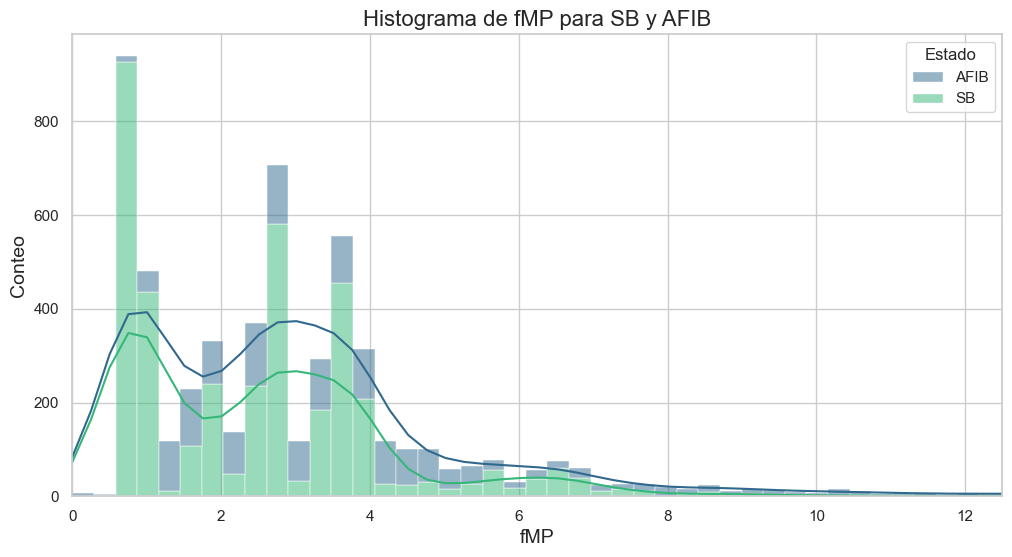

In [279]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot the histogram
sns.histplot(data=result_append, x='fMP', hue='Estado', multiple='stack', kde=True, palette='viridis')

# Add titles and labels
plt.title('Histograma de fMP para SB y AFIB', fontsize=16)
plt.xlabel('fMP', fontsize=14)
plt.ylabel('Conteo', fontsize=14)

# Show the plot
plt.xlim([0,12.5])
plt.show()

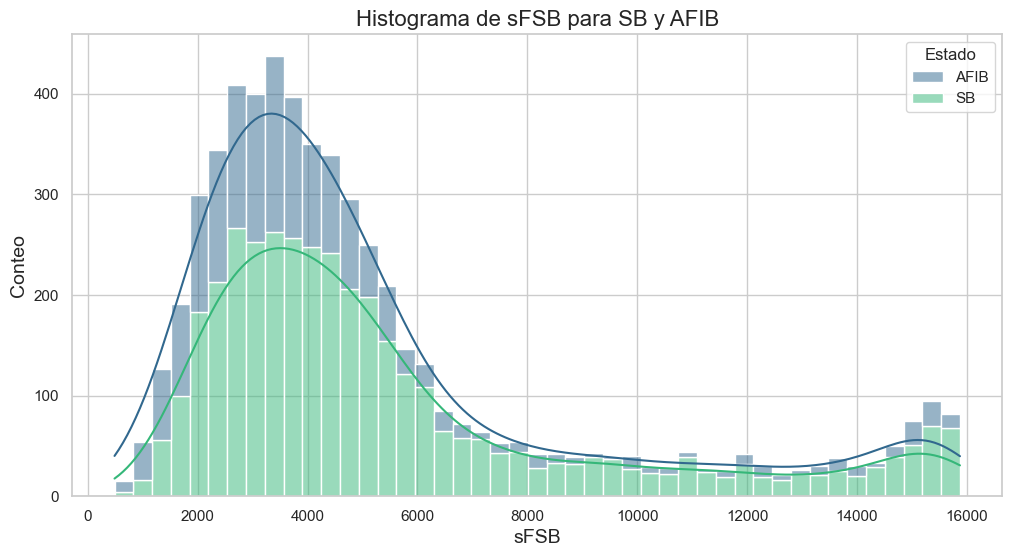

In [280]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot the histogram
sns.histplot(data=result_append, x='sFSB', hue='Estado', multiple='stack', kde=True, palette='viridis')

# Add titles and labels
plt.title('Histograma de sFSB para SB y AFIB', fontsize=16)
plt.xlabel('sFSB', fontsize=14)
plt.ylabel('Conteo', fontsize=14)

# Show the plot
plt.show()

/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/2092615862.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result_append, x='Estado', y='fMP', palette='viridis')


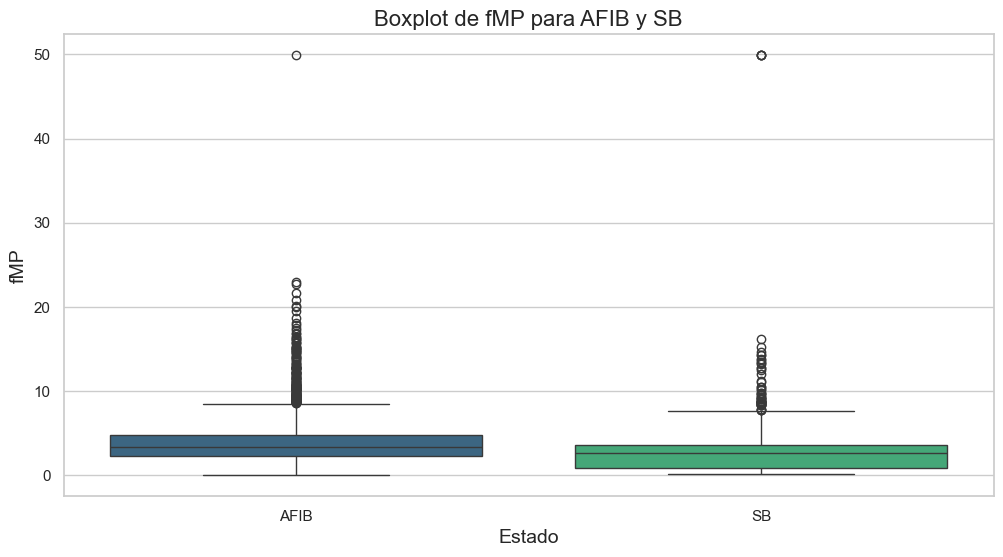

In [281]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Create the boxplot
sns.boxplot(data=result_append, x='Estado', y='fMP', palette='viridis')

# Add titles and labels
plt.title('Boxplot de fMP para AFIB y SB', fontsize=16)
plt.xlabel('Estado', fontsize=14)
plt.ylabel('fMP', fontsize=14)

# Show the plot
plt.show()

/var/folders/cz/nwy4xdnj77j0w2l0v6vdd11m0000gn/T/ipykernel_7111/174401610.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result_append, x='Estado', y='sFSB', palette='viridis')


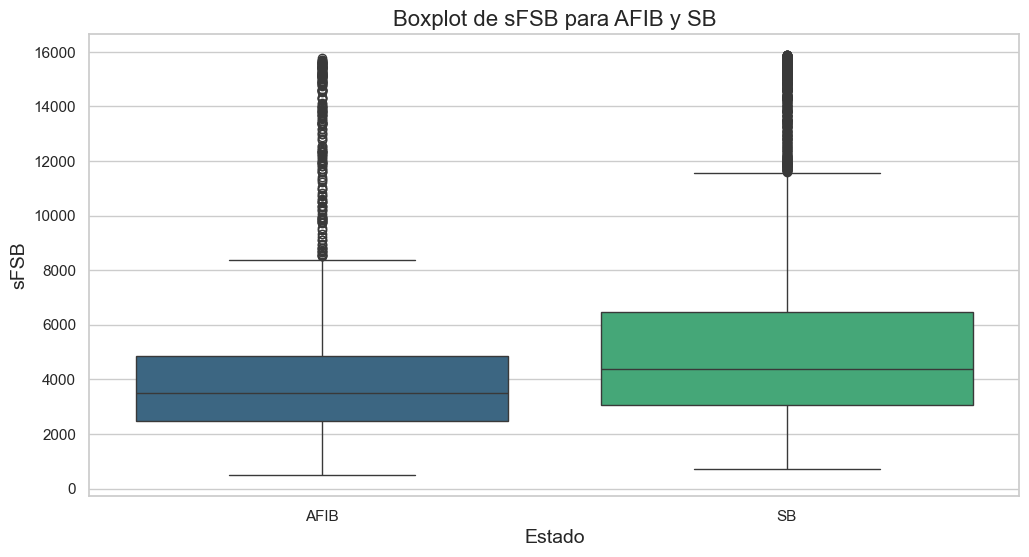

In [282]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Create the boxplot
sns.boxplot(data=result_append, x='Estado', y='sFSB', palette='viridis')

# Add titles and labels
plt.title('Boxplot de sFSB para AFIB y SB', fontsize=16)
plt.xlabel('Estado', fontsize=14)
plt.ylabel('sFSB', fontsize=14)

# Show the plot
plt.show()

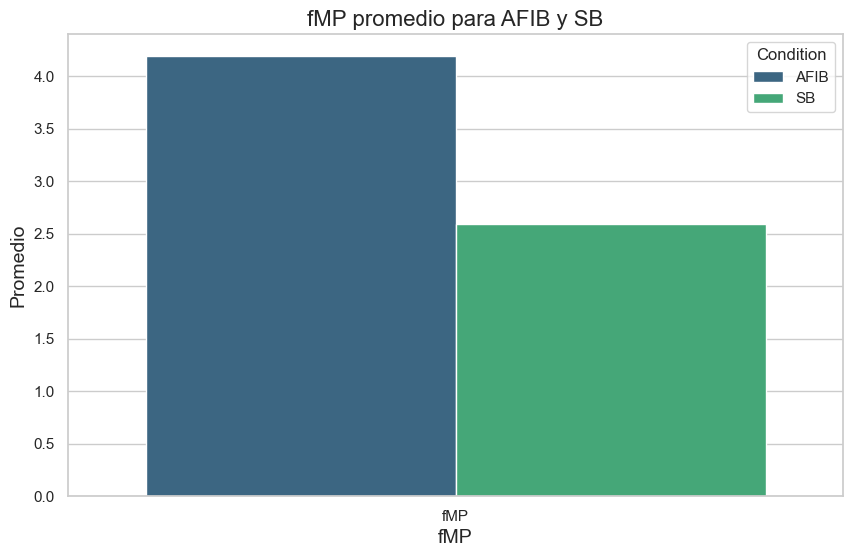

In [283]:
# Calculate mean fMP for AFIB and SB
mean_fMP_AFIB = df_AFIB['fMP'].mean()
mean_fMP_SB = df_SB['fMP'].mean()

# Create a DataFrame for plotting
mean_values = pd.DataFrame({
    'Metric': ['fMP'],
    'AFIB': [mean_fMP_AFIB],
    'SB': [mean_fMP_SB]
})

# Plot the mean fMP for AFIB and SB
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='value', hue='variable', data=pd.melt(mean_values, id_vars=['Metric']), palette='viridis')
plt.title('fMP promedio para AFIB y SB', fontsize=16)
plt.xlabel('fMP', fontsize=14)
plt.ylabel('Promedio', fontsize=14)
plt.legend(title='Condition')
plt.show()

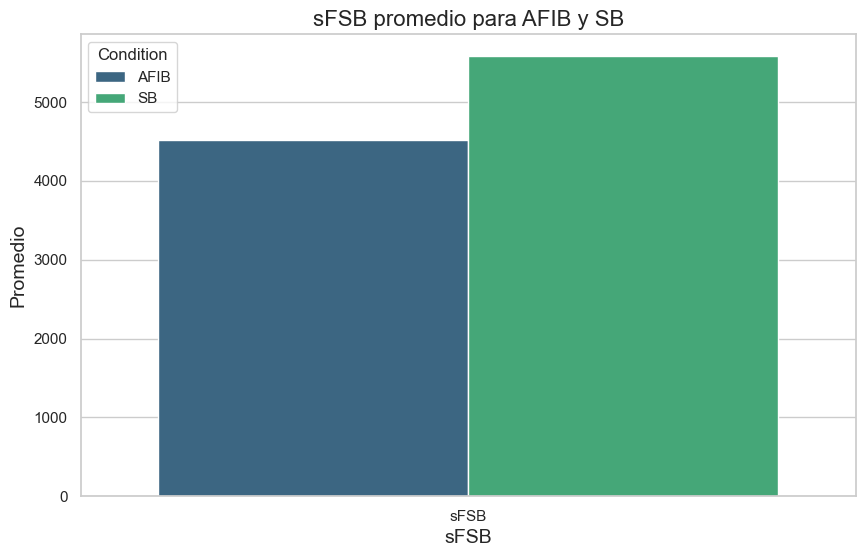

In [284]:
# Calculate mean sFSB for AFIB and SB
mean_sFSB_AFIB = df_AFIB['sFSB'].mean()
mean_sFSB_SB = df_SB['sFSB'].mean()

# Create a DataFrame for plotting
mean_values_sFSB = pd.DataFrame({
    'Metric': ['sFSB'],
    'AFIB': [mean_sFSB_AFIB],
    'SB': [mean_sFSB_SB]
})

# Plot the mean sFSB for AFIB and SB
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='value', hue='variable', data=pd.melt(mean_values_sFSB, id_vars=['Metric']), palette='viridis')
plt.title('sFSB promedio para AFIB y SB', fontsize=16)
plt.xlabel('sFSB', fontsize=14)
plt.ylabel('Promedio', fontsize=14)
plt.legend(title='Condition')
plt.show()

# Análisis de diferencia estadistica

In [287]:
df = result_append
# Separar los datos en dos grupos: SB y AFIB
df_SB = df[df['Estado'] == 'SB']
df_AFIB = df[df['Estado'] == 'AFIB']

# Función para evaluar la normalidad
def evaluar_normalidad(data, variable):
    if data.isnull().any():  # Verificar si hay valores NaN
        print(f"Advertencia: Hay valores NaN en los datos de {variable}.")
        data = data.dropna()  # Opcional: eliminar NaNs

    # Realizar la prueba de Shapiro-Wilk
    stat, p_value = stats.shapiro(data)
    print(f"Resultados de la Prueba de Shapiro-Wilk para {variable}:")
    print(f"Estadístico: {stat}, p-valor: {p_value}")

    if p_value > 0.05:
        print(f"Los datos de {variable} parecen seguir una distribución normal.\n")
        return True  # Normal
    else:
        print(f"Los datos de {variable} no siguen una distribución normal.\n")
        return False  # No normal

# Variables a analizar
variables = ['fMP', 'sFSB']

# Evaluar la normalidad en SB y AFIB
for variable in variables:
    print(f"\nEvaluación de la normalidad para {variable}:")
    normal_SB = evaluar_normalidad(df_SB[variable], f"SB - {variable}")
    normal_AFIB = evaluar_normalidad(df_AFIB[variable], f"AFIB - {variable}")

    # Seleccionar la prueba estadística adecuada
    if normal_SB and normal_AFIB:
        # Prueba paramétrica (T-test)
        t_stat, p_value = stats.ttest_ind(df_SB[variable], df_AFIB[variable], equal_var=False)
        print(f"Prueba T para {variable}: t = {t_stat}, p-valor = {p_value}\n")
    else:
        # Prueba no paramétrica (Mann-Whitney U)
        u_stat, p_value = stats.mannwhitneyu(df_SB[variable], df_AFIB[variable], alternative='two-sided')
        print(f"Prueba Mann-Whitney U para {variable}: u = {u_stat}, p-valor = {p_value}\n")



Evaluación de la normalidad para fMP:
Resultados de la Prueba de Shapiro-Wilk para SB - fMP:
Estadístico: 0.5874751801198713, p-valor: 2.7119526978754692e-70
Los datos de SB - fMP no siguen una distribución normal.

Resultados de la Prueba de Shapiro-Wilk para AFIB - fMP:
Estadístico: 0.7413084430737846, p-valor: 2.780253778686919e-46
Los datos de AFIB - fMP no siguen una distribución normal.

Prueba Mann-Whitney U para fMP: u = 2140996.5, p-valor = 2.8265963017499422e-118


Evaluación de la normalidad para sFSB:
Resultados de la Prueba de Shapiro-Wilk para SB - sFSB:
Estadístico: 0.8231691269907291, p-valor: 2.348448851075373e-54
Los datos de SB - sFSB no siguen una distribución normal.

Resultados de la Prueba de Shapiro-Wilk para AFIB - sFSB:
Estadístico: 0.7494695435136807, p-valor: 8.852326361188976e-46
Los datos de AFIB - sFSB no siguen una distribución normal.

Prueba Mann-Whitney U para sFSB: u = 4244311.0, p-valor = 1.1232977376429551e-42



In [288]:
# Separar los datos en dos grupos: SB y AFIB
grupo_SB = df[df['Estado'] == 'SB']
grupo_AFIB = df[df['Estado'] == 'AFIB']

# Estadística descriptiva para SB y AFIB
descriptiva_SB = grupo_SB[['fMP', 'sFSB']].describe()
descriptiva_AFIB = grupo_AFIB[['fMP', 'sFSB']].describe()

print("Estadística descriptiva para SB:")
print(descriptiva_SB)

print("\nEstadística descriptiva para AFIB:")
print(descriptiva_AFIB)

# Realizar pruebas estadísticas entre los grupos SB y AFIB
# 1. T-test para la frecuencia de máxima potencia (fMP)
t_test_fMP = stats.ttest_ind(grupo_SB['fMP'], grupo_AFIB['fMP'], equal_var=False)

# 2. T-test para la potencia de la señal (sFSB)
t_test_sFSB = stats.ttest_ind(grupo_SB['sFSB'], grupo_AFIB['sFSB'], equal_var=False)

# Resultados de las pruebas t
print("\nT-test para la frecuencia de máxima potencia (fMP):", t_test_fMP)
print("T-test para la potencia de la señal (sFSB):", t_test_sFSB)

Estadística descriptiva para SB:
               fMP          sFSB
count  3889.000000   3889.000000
mean      2.592556   5581.046027
std       2.380570   3705.405792
min       0.100020    717.000000
25%       0.900180   3061.000000
50%       2.600520   4370.000000
75%       3.600720   6465.000000
max      49.909982  15876.000000

Estadística descriptiva para AFIB:
               fMP          sFSB
count  1780.000000   1780.000000
mean      4.190501   4519.478652
std       3.284344   3389.603231
min       0.000000    487.000000
25%       2.300460   2492.250000
50%       3.300660   3501.000000
75%       4.800960   4868.000000
max      49.909982  15776.000000

T-test para la frecuencia de máxima potencia (fMP): TtestResult(statistic=np.float64(-18.430252610890335), pvalue=np.float64(1.7172694543025388e-71), df=np.float64(2666.871783125148))
T-test para la potencia de la señal (sFSB): TtestResult(statistic=np.float64(10.623536189827128), pvalue=np.float64(5.410519282678292e-26), df=np.float6